# Media Alignment: Debates x Media

This notebook documents the **Media–Debate Alignment pipeline** for the BSc thesis:  
`Debates, Media, and Discourse: A Computational Analysis of Temporal Shifts in U.S. Presidential Debates and Media Framing Across the Political Spectrum`, written by **Emma Cristina Mora** (emma.mora@studbocconi.it) at **Bocconi University** under the supervision of **Professor Carlo Rasmus Schwarz**.

The purpose of this stage is to align **media coverage** (Factiva articles from *New York Times*, *Wall Street Journal*, and *New York Post*) with **debate themes and subthemes** extracted from U.S. presidential debates. This allows us to compare how discourse in debates relates to media framing across outlets and election cycles.

**Media Dataset Creation**
- Media articles were collected from **Factiva**, filtered by election years and thematic queries (e.g., *foreign policy*, *healthcare*, *immigration*).
- Articles were normalized (UTF-8 cleaning, spacing, case standardization) and chunked into ~250-word windows with 50-word overlap for embedding.
- Metadata includes: `year`, `outlet`, `headline`, `theme` (query label), and unique article IDs.

**Debates Dataset Alignment**
- Debates were previously processed into utterances and annotated with **themes** and **subthemes** (see `debates_df_themes.csv`).
- In this notebook, debates are filtered to match the **2012–2024** media window.
- Stable IDs (`__debate_id`, `__media_id`) are assigned for consistent mapping.

**Notebook Summary**
- Section 3 aligns debates to media years and shared themes.
- Section 4 prepares text for embeddings (normalization, chunking).
- Section 5 encodes debates and media using **SBERT** (`all-MiniLM-L6-v2`).
- Section 6 computes **theme and subtheme centroids**, assigns them to media chunks, and performs diagnostics.
- Section 7 exports full predictions, filtered sets, and balanced subsets for downstream analysis.

## 1. Introduction and Config

In [2]:
# === LIBRARIES ===

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import tqdm

In [3]:
# === PATHS & CONSTANTS ===

REPO_DIR   = Path(".").resolve().parents[0]
DATA_DIR   = REPO_DIR / "data"
MEDIA_DIR  = DATA_DIR / "media"

DEBATES_FILE = DATA_DIR / "debates_df_themes.csv"
MEDIA_FILE  = DATA_DIR / "media_articles_dataset.csv"

# confirm setup
print("Repository Path:", REPO_DIR)
print("Data Directory:", DATA_DIR)
print("Debates Dataset:", DEBATES_FILE)
print("Media Dataset:", MEDIA_FILE)

# reproducibility
RANDOM_SEED = 42

Repository Path: /Users/emmamora/Documents/GitHub/thesis
Data Directory: /Users/emmamora/Documents/GitHub/thesis/data
Debates Dataset: /Users/emmamora/Documents/GitHub/thesis/data/debates_df_themes.csv
Media Dataset: /Users/emmamora/Documents/GitHub/thesis/data/media_articles_dataset.csv


## 2. Load Data

In [4]:
# === DEBATES DATASET ===

# load debates dataset and inspect schema
df_debates = pd.read_csv(DEBATES_FILE)

print(f"[INFO] Debates dataset loaded: {len(df_debates):,} rows")
print(df_debates.head(3))
print("\n[INFO] Columns:", list(df_debates.columns))

[INFO] Debates dataset loaded: 6,316 rows
                                                text speaker_normalized  \
0  good evening. the television and radio station...          Moderator   
1  mr. smith, mr. nixon. in the election of 1860,...        Candidate_D   
2  mr. smith, senator kennedy. the things that se...        Candidate_R   

     speaker       party   winner winner_party  year   debate_type  \
0  Moderator         NaN  Kennedy     Democrat  1960  presidential   
1    Kennedy    Democrat  Kennedy     Democrat  1960  presidential   
2      Nixon  Republican  Kennedy     Democrat  1960  presidential   

                           debate_id                           utterance_id  \
0  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_001   
1  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_002   
2  1960_1_Presidential_Nixon_Kennedy  1960_1_Presidential_Nixon_Kennedy_004   

                                     lemmatized_text  token

In [5]:
# === MEDIA DATASET ===

# load media dataset and inspect schema
df_media = pd.read_csv(MEDIA_FILE)

print(f"[INFO] Media dataset loaded: {len(df_media):,} rows")
print(df_media.head(3))
print("\n[INFO] Columns:", list(df_media.columns))

[INFO] Media dataset loaded: 1,031 rows
   year                             theme outlet outlet_leaning  \
0  2012  foreign_policy_national_security    nyp              R   
1  2012  foreign_policy_national_security    nyp              R   
2  2012  foreign_policy_national_security    nyp              R   

   article_number                                           headline  \
0               1  America Decides O blows his bam dunk Foreign-p...   
1               2  America Decides O blows his bam dunk Foreign-p...   
2               3  America Decides Desperate Bam 'bombs' Romney B...   

                                                body  \
0  The debate, in Boca Raton, Fla., is supposed t...   
1  The debate, in Boca Raton, Fla., is supposed t...   
2  "I know you haven't been in a position to actu...   

                                         source_file  body_words  body_len  
0  factiva_foreign_policy_national_security_2012_...         716      4327  
1  factiva_foreign_poli

## 3. Alignment Window

In [6]:
# === THEME & YEAR DETECTION ===

# config
INCLUDE_NOISE_THEME = True  # set True since we want to keep "noise_or_unspecified" in debates

# detect theme columns (debates uses theme_name/subtheme_name; media uses theme)
DEBATE_THEME_COL = "theme_name" if "theme_name" in df_debates.columns else ("theme" if "theme" in df_debates.columns else None)
if DEBATE_THEME_COL is None:
    raise ValueError("Could not find a theme column in debates dataset (expected 'theme_name' or 'theme').")

MEDIA_THEME_COL = "theme" if "theme" in df_media.columns else None
if MEDIA_THEME_COL is None:
    raise ValueError("Could not find 'theme' column in media dataset.")

# media-driven year window
media_year_min = int(df_media["year"].min())
media_year_max = int(df_media["year"].max())

print(f"[INFO] Media year window: {media_year_min}–{media_year_max}")

[INFO] Media year window: 2012–2024


In [7]:
# === ALIGN DEBATES TO MEDIA YEARS ===

# filter debates by media year window
df_debates_aligned = df_debates[df_debates["year"].between(media_year_min, media_year_max)].copy()

# optionally drop noise in debates
if not INCLUDE_NOISE_THEME and DEBATE_THEME_COL in df_debates_aligned.columns:
    before_n = len(df_debates_aligned)
    df_debates_aligned = df_debates_aligned[df_debates_aligned[DEBATE_THEME_COL] != "noise_or_unspecified"].copy()
    print(f"[CLEAN] Dropped noise_or_unspecified themes from debates: {before_n - len(df_debates_aligned)} rows")

# quick check
print(f"[INFO] Aligned debates dataset: {len(df_debates_aligned):,} rows")
display(df_debates_aligned.head(3))

# save filtered debates snapshot for reproducibility
aligned_path = DATA_DIR / "important"/ "debates_df_themes_media_aligned.csv"
df_debates_aligned.to_csv(aligned_path, index=False)
print(f"[SAVED] Aligned debates: {aligned_path}")

[INFO] Aligned debates dataset: 2,980 rows


,text,speaker_normalized,speaker,party,winner,winner_party,year,debate_type,debate_id,utterance_id,lemmatized_text,token_count,decade,party_code,topic,probability,theme_name,subtheme_name,subtopic,subtopic_prob
3336,good evening from the magness arena at the uni...,Moderator,Moderator,NaN,Obama,Democrat,2012,presidential,2012_1_Presidential_Romney_Obama,2012_1_Presidential_Romney_Obama_001,good evening from the magness arena at the uni...,244,2010s,NaN,6,1.000000,debate_format_procedure,debate_structure_and_sponsorship,1.0,0.829317
3337,"gentlemen, welcome to you both. let's start th...",Moderator,Moderator,NaN,Obama,Democrat,2012,presidential,2012_1_Presidential_Romney_Obama,2012_1_Presidential_Romney_Obama_002,gentleman welcome to you both let us start the...,59,2010s,NaN,-1,0.157784,noise_or_unspecified,NaN,NaN,NaN
3338,"well, thank you very much, jim, for this oppor...",Candidate_D,Obama,Democrat,Obama,Democrat,2012,presidential,2012_1_Presidential_Romney_Obama,2012_1_Presidential_Romney_Obama_003,well thank you very much jim for this opportun...,394,2010s,D,-1,0.038096,noise_or_unspecified,NaN,NaN,NaN


[SAVED] Aligned debates: /Users/emmamora/Documents/GitHub/thesis/data/debates_df_themes_media_aligned.csv


In [8]:
# === SHARED THEMES ===

# align on shared themes (intersection of normalized strings)
debate_themes = set(df_debates_aligned[DEBATE_THEME_COL].dropna().astype(str).str.strip().unique())
media_themes  = set(df_media[MEDIA_THEME_COL].dropna().astype(str).str.strip().unique())
shared_themes = sorted(debate_themes.intersection(media_themes))

print(f"[INFO] Themes — debates: {len(debate_themes)} | media: {len(media_themes)} | shared: {len(shared_themes)}")
print("[INFO] Shared themes:", shared_themes)

[INFO] Themes — debates: 17 | media: 3 | shared: 2
[INFO] Shared themes: ['foreign_policy_national_security', 'immigration_borders']


In the debates, we called one theme "healthcare_social_security", while in media we used: ""healthcare_public_health". We will carefully map one to the other based on centroids of debates topics.

In [9]:
# === QUICK CHECKS: subtheme presence & health ===
DEBATE_SUB_COL = "subtheme_name" if "subtheme_name" in df_debates_aligned.columns else None
print("[INFO] Subtheme column:", DEBATE_SUB_COL)

if DEBATE_SUB_COL is None:
    print("[WARN] No subtheme column in debates; subtheme centroids will be skipped.")
else:
    print("[INFO] non-null subtheme rows:",
          df_debates_aligned[DEBATE_SUB_COL].notna().sum(), "of", len(df_debates_aligned))
    # a few examples
    display(
        df_debates_aligned[[DEBATE_THEME_COL, DEBATE_SUB_COL, "speaker_normalized", "text"]]
        .dropna(subset=[DEBATE_SUB_COL]).sample(5, random_state=RANDOM_SEED)
    )

[INFO] Subtheme column: subtheme_name
[INFO] non-null subtheme rows: 1208 of 2980


,theme_name,subtheme_name,speaker_normalized,text
3601,leadership_executive_experience,medicare_prescription_drugs,Candidate_D,that would — that would be a first for the rep...
5075,leadership_executive_experience,affordable_care_health_insurance,Candidate_D,look he's the deal. i got very lucky. i'm goin...
4125,leadership_executive_experience,affordable_care_health_insurance,Candidate_D,"why not? yeah, why not? [ laughter ] you know,..."
3612,tax_policy,tax_cuts_policy_proposals,Candidate_R,you can — you can cut tax rates by 20 percent ...
4836,foreign_policy_national_security,russia_soviet_union,Candidate_D,"well, if you went on to read the rest of the s..."


## 4. Text Prep for Embeddings

In [10]:
# === CONFIG: TEXT COLUMNS & SIMPLE NORMALIZATION ===

# define text and theme columns

DEBATE_TEXT_COL  = "text"          # debates free text column (utterance)
DEBATE_THEME_COL = "theme_name"    # debates theme column
DEBATE_SUB_COL   = "subtheme_name" if "subtheme_name" in df_debates.columns else None

MEDIA_TEXT_COL   = "body"          # media article text (cleaned body)
MEDIA_THEME_COL  = "theme"         # media theme label from query (source label)

# sanity checks
for _c in [DEBATE_TEXT_COL, DEBATE_THEME_COL, "year"]:
    assert _c in df_debates_aligned.columns, f"Missing debates column: {_c}"

for _c in [MEDIA_TEXT_COL, MEDIA_THEME_COL, "year", "outlet"]:
    assert _c in df_media.columns, f"Missing media column: {_c}"

# lightweight normalizer (preserve meaning, strip weird spaces)
def _norm_txt(s: str) -> str:
    if not isinstance(s, str): 
        return ""
    s = (s.replace("\u00a0", " ")
           .replace("\u200b", " ")
           .replace("\ufeff", " "))
    s = re.sub(r"[ \t]+", " ", s)        # collapse runs of spaces/tabs
    s = re.sub(r"\s+\n", "\n", s)        # trim space-before-newline
    s = re.sub(r"\n\s+", "\n", s)        # trim space-after-newline
    s = re.sub(r"\n{3,}", "\n\n", s)     # collapse too many blank lines
    return s.strip()

print("[INFO] Normalizing text columns …")
df_debates_aligned["text"] = df_debates_aligned[DEBATE_TEXT_COL].astype(str).apply(_norm_txt)
df_media["text"]   = df_media[MEDIA_TEXT_COL].astype(str).apply(_norm_txt)

display(df_debates_aligned[["year", DEBATE_THEME_COL, "speaker_normalized", "party", "text"]].head(3))
display(df_media[["year", MEDIA_THEME_COL, "outlet", "headline", "text"]].head(3))

[INFO] Normalizing text columns …


,year,theme_name,speaker_normalized,party,text
3336,2012,debate_format_procedure,Moderator,NaN,good evening from the magness arena at the uni...
3337,2012,noise_or_unspecified,Moderator,NaN,"gentlemen, welcome to you both. let's start th..."
3338,2012,noise_or_unspecified,Candidate_D,Democrat,"well, thank you very much, jim, for this oppor..."


,year,theme,outlet,headline,text
0,2012,foreign_policy_national_security,nyp,America Decides O blows his bam dunk Foreign-p...,"The debate, in Boca Raton, Fla., is supposed t..."
1,2012,foreign_policy_national_security,nyp,America Decides O blows his bam dunk Foreign-p...,"The debate, in Boca Raton, Fla., is supposed t..."
2,2012,foreign_policy_national_security,nyp,America Decides Desperate Bam 'bombs' Romney B...,"""I know you haven't been in a position to actu..."


In [11]:
# === MEDIA CHUNKING & EMBEDDING PREP ===

# lower-case media body (after your normalization above)
df_media["text"] = df_media["text"].astype(str).str.lower()

# give both tables stable ids for later joins
DEBATE_ID_COL = "__debate_id"
MEDIA_ID_COL  = "__media_id"
if DEBATE_ID_COL not in df_debates_aligned.columns:
    df_debates_aligned[DEBATE_ID_COL] = np.arange(len(df_debates_aligned))
if MEDIA_ID_COL not in df_media.columns:
    df_media[MEDIA_ID_COL] = np.arange(len(df_media))

# word-based chunker: ~250 words with 50-word overlap
TARGET_WORDS  = 250
OVERLAP_WORDS = 50

def split_to_word_chunks(text: str, target_words: int = 250, overlap: int = 50):
    """Return list of word-window chunks for a given text."""
    if not isinstance(text, str) or not text.strip():
        return []
    words = re.findall(r"\S+", text)
    if not words:
        return []
    chunks = []
    start = 0
    n = len(words)
    while start < n:
        end = min(start + target_words, n)
        chunks.append(" ".join(words[start:end]))
        if end >= n:
            break
        # slide window with overlap
        start = max(0, end - overlap)
        if start >= n:
            break
    return chunks

print("[INFO] Chunking media bodies …")
chunk_rows = []
for _, r in df_media.iterrows():
    chunks = split_to_word_chunks(r["text"], TARGET_WORDS, OVERLAP_WORDS)
    if not chunks:
        continue
    for i, ch in enumerate(chunks, start=1):
        chunk_rows.append({
            MEDIA_ID_COL:   r[MEDIA_ID_COL],
            "year":         int(r["year"]),
            "outlet":       r["outlet"],
            "source_theme": r["theme"],       # original theme from your query
            "headline":     r.get("headline", ""),
            "chunk_index":  i,
            "chunk_text":   ch
        })

df_media_chunks = pd.DataFrame(chunk_rows)
print(f"[INFO] Media chunks built: {len(df_media_chunks):,} chunks from {len(df_media):,} articles "
      f"(avg {len(df_media_chunks)/max(len(df_media),1):.2f} chunks/article)")
display(df_media_chunks.head(3))

[INFO] Chunking media bodies …
[INFO] Media chunks built: 5,050 chunks from 1,031 articles (avg 4.90 chunks/article)


,__media_id,year,outlet,source_theme,headline,chunk_index,chunk_text
0,0,2012,nyp,foreign_policy_national_security,America Decides O blows his bam dunk Foreign-p...,1,"the debate, in boca raton, fla., is supposed t..."
1,0,2012,nyp,foreign_policy_national_security,America Decides O blows his bam dunk Foreign-p...,2,evidence the motive was terrorism. obama said ...
2,0,2012,nyp,foreign_policy_national_security,America Decides O blows his bam dunk Foreign-p...,3,"they are, have to be understood as part of liv..."


In [12]:
# === PREP FOR EMBEDDING ===

# slim embedding frames
cols = [DEBATE_ID_COL, "year", DEBATE_THEME_COL, "text"]
if DEBATE_SUB_COL is not None and DEBATE_SUB_COL in df_debates_aligned.columns:
    cols.insert(3, DEBATE_SUB_COL)  # place subtheme right after theme
df_debates_embed = df_debates_aligned[cols].copy()
df_media_embed   = df_media_chunks[[MEDIA_ID_COL, "year", "outlet", "source_theme", "chunk_index", "chunk_text"]].copy()

# quick sanity previews
display(df_media_embed.head(3))
display(df_debates_embed.head(3))

# save prep snapshots so you can restart from here without re-running earlier steps
PREP_DIR = DATA_DIR / "interim"
PREP_DIR.mkdir(parents=True, exist_ok=True)
df_media_embed.to_csv(PREP_DIR / "media_chunks_prep.csv", index=False)
df_debates_embed.to_csv(PREP_DIR / "debates_aligned_prep.csv", index=False)
print("[SAVED] media_chunks_prep.csv & debates_aligned_prep.csv →", PREP_DIR)

,__media_id,year,outlet,source_theme,chunk_index,chunk_text
0,0,2012,nyp,foreign_policy_national_security,1,"the debate, in boca raton, fla., is supposed t..."
1,0,2012,nyp,foreign_policy_national_security,2,evidence the motive was terrorism. obama said ...
2,0,2012,nyp,foreign_policy_national_security,3,"they are, have to be understood as part of liv..."


,__debate_id,year,theme_name,subtheme_name,text
3336,0,2012,debate_format_procedure,debate_structure_and_sponsorship,good evening from the magness arena at the uni...
3337,1,2012,noise_or_unspecified,NaN,"gentlemen, welcome to you both. let's start th..."
3338,2,2012,noise_or_unspecified,NaN,"well, thank you very much, jim, for this oppor..."


[SAVED] media_chunks_prep.csv & debates_aligned_prep.csv → /Users/emmamora/Documents/GitHub/thesis/data/interim


## 5. Embedding Setup & Encoding (SBERT)

In [13]:
# === SBERT LOADER & ENCODER ===

from sentence_transformers import SentenceTransformer
import torch
import numpy as np

# paths to store embeddings
EMB_DIR = DATA_DIR / "embeddings"
EMB_DIR.mkdir(parents=True, exist_ok=True)

# ids defined in Section 4
DEBATE_ID_COL = "__debate_id"
MEDIA_ID_COL  = "__media_id"

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE = 64
NORMALIZE  = True  # cosine-space ready

# device pick
DEVICE = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"[SBERT] Loading {MODEL_NAME} on {DEVICE} …")
sbert = SentenceTransformer(MODEL_NAME, device=DEVICE)

def encode_texts(texts, batch_size=BATCH_SIZE, normalize=NORMALIZE):
    """Encode a list/Series of strings → np.ndarray [N, d]."""
    emb = sbert.encode(
        list(texts),
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=normalize,
        show_progress_bar=True,
    )
    return emb

/Users/emmamora/anaconda3/envs/thesis-nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[SBERT] Loading sentence-transformers/all-MiniLM-L6-v2 on mps …


/Users/emmamora/anaconda3/envs/thesis-nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
# === EMBED ALIGNED DEBATES ===

# sanity check
assert {"text", DEBATE_ID_COL}.issubset(df_debates_embed.columns)

print(f"[ENC] Debates to embed: {len(df_debates_embed):,}")
debate_emb = encode_texts(df_debates_embed["text"])

debate_emb_path = EMB_DIR / "debates_aligned_sbert.npy"
debate_map_path = EMB_DIR / "debates_aligned_index.csv"

np.save(debate_emb_path, debate_emb)
df_debates_embed.to_csv(debate_map_path, index=False)

print(f"[SAVED] debates embeddings: {debate_emb.shape} → {debate_emb_path}")
print(f"[SAVED] debates index map → {debate_map_path}")

[ENC] Debates to embed: 2,980


Batches: 100%|██████████| 47/47 [00:07<00:00,  5.98it/s]

[SAVED] debates embeddings: (2980, 384) → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/debates_aligned_sbert.npy
[SAVED] debates index map → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/debates_aligned_index.csv


In [15]:
# === EMBED MEDIA CHUNKS ===

# sanity check
assert {"chunk_text", MEDIA_ID_COL}.issubset(df_media_embed.columns)

print(f"[ENC] Media chunks to embed: {len(df_media_embed):,}")
media_emb = encode_texts(df_media_embed["chunk_text"])

media_emb_path = EMB_DIR / "media_chunks_sbert.npy"
media_map_path = EMB_DIR / "media_chunks_index.csv"

np.save(media_emb_path, media_emb)
df_media_embed.to_csv(media_map_path, index=False)

print(f"[SAVED] media embeddings: {media_emb.shape} → {media_emb_path}")
print(f"[SAVED] media index map → {media_map_path}")

# quick sanity check (cosine to self ~ 1.0 if normalized)
from numpy.linalg import norm
cs = (media_emb[0] @ media_emb[0]) / (norm(media_emb[0]) * norm(media_emb[0]) + 1e-12)
print(f"[QC] Cosine(media[0], media[0]) = {cs:.6f}")

[ENC] Media chunks to embed: 5,050


Batches: 100%|██████████| 79/79 [00:27<00:00,  2.86it/s]


[SAVED] media embeddings: (5050, 384) → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/media_chunks_sbert.npy
[SAVED] media index map → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/media_chunks_index.csv
[QC] Cosine(media[0], media[0]) = 1.000000


In [16]:
# === INTEGRITY CHECKS ===

# load back and confirm alignment
debate_emb_path = EMB_DIR / "debates_aligned_sbert.npy"
debate_map_path = EMB_DIR / "debates_aligned_index.csv"
media_emb_path  = EMB_DIR / "media_chunks_sbert.npy"
media_map_path  = EMB_DIR / "media_chunks_index.csv"

deb_emb  = np.load(debate_emb_path)
deb_idx  = pd.read_csv(debate_map_path)
med_emb  = np.load(media_emb_path)
med_idx  = pd.read_csv(media_map_path)

print("[CHECK] debates:", deb_emb.shape, "| index rows:", len(deb_idx))
print("[CHECK] media  :", med_emb.shape, "| index rows:", len(med_idx))

assert deb_emb.shape[0] == len(deb_idx), "Debates embedding rows != index rows"
assert med_emb.shape[0] == len(med_idx),  "Media embedding rows != index rows"
assert deb_emb.dtype == np.float32 or deb_emb.dtype == np.float64
assert med_emb.dtype == np.float32 or med_emb.dtype == np.float64

print("[OK] embeddings ↔ index alignment confirmed.")

[CHECK] debates: (2980, 384) | index rows: 2980
[CHECK] media  : (5050, 384) | index rows: 5050
[OK] embeddings ↔ index alignment confirmed.


In [17]:
# === PRECOMPUTE DEBATE THEME CENTROIDS (2012–2024) ===

from collections import defaultdict

# join embeddings to their rows
deb_all = deb_idx.copy()
deb_all["__row"] = np.arange(len(deb_all))
# ensure the column name matches your theme col from 4
THEME_COL = DEBATE_THEME_COL  # "theme_name"
assert THEME_COL in deb_all.columns

# group indices by theme
theme_to_rows = defaultdict(list)
for i, r in deb_all.iterrows():
    theme_to_rows[str(r[THEME_COL])].append(int(r["__row"]))

# compute centroids (already normalized -> mean then renormalize)
def _l2norm(x, eps=1e-12):
    n = np.linalg.norm(x, axis=1, keepdims=True)
    return x / (n + eps)

centroids = {}
for theme, rows in theme_to_rows.items():
    vecs = deb_emb[rows]
    c = vecs.mean(axis=0, dtype=np.float32)
    c = c / (np.linalg.norm(c) + 1e-12)
    centroids[theme] = c

# save
centroid_mat = np.stack(list(centroids.values()), axis=0)
centroid_themes = list(centroids.keys())

np.save(EMB_DIR / "debate_theme_centroids.npy", centroid_mat)
pd.DataFrame({"theme": centroid_themes}).to_csv(EMB_DIR / "debate_theme_centroids_index.csv", index=False)

print("[SAVED] debate theme centroids:", centroid_mat.shape, "→", EMB_DIR / "debate_theme_centroids.npy")
print("[SAVED] centroid index csv →", EMB_DIR / "debate_theme_centroids_index.csv")

[SAVED] debate theme centroids: (17, 384) → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/debate_theme_centroids.npy
[SAVED] centroid index csv → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/debate_theme_centroids_index.csv


## 6. Similarity & Quick Diagnostics

### 6.1. Centroids: Themes & Subthemes

In [18]:
# === LOAD DEBATE THEME CENTROIDS ===

CENTROID_NPY = EMB_DIR / "debate_theme_centroids.npy"
CENTROID_IDX = EMB_DIR / "debate_theme_centroids_index.csv"

centroid_mat  = np.load(CENTROID_NPY)             # [T, d], L2-normalized
centroid_idx  = pd.read_csv(CENTROID_IDX)         # ["theme"]
centroid_themes = list(centroid_idx["theme"])

IGNORE_THEMES = {"noise_or_unspecified"}          # add 'debate_format_procedure' if you wish
mask = [t not in IGNORE_THEMES for t in centroid_themes]
centroid_mat   = centroid_mat[mask]
centroid_themes = [t for t, keep in zip(centroid_themes, mask) if keep]

print(f"[INFO] Using {len(centroid_themes)} debate centroids for assignment.")
print("[INFO] Themes:", centroid_themes[:8], "...")  # preview

[INFO] Using 16 debate centroids for assignment.
[INFO] Themes: ['debate_format_procedure', 'tax_policy', 'leadership_executive_experience', 'government_spending_budget', 'healthcare_social_security', 'energy_environment', 'partisan_gridlock_new_leadership', 'education_public_schools'] ...


In [19]:
# === BUILD SUBTHEME CENTROIDS (optional) ===

deb_map = pd.read_csv(EMB_DIR / "debates_aligned_index.csv")  # has theme + (now) subtheme
deb_emb = np.load(EMB_DIR / "debates_aligned_sbert.npy")      # same row order as deb_map

assert len(deb_map) == len(deb_emb), "index ↔ embedding mismatch"

if DEBATE_SUB_COL is None or DEBATE_SUB_COL not in deb_map.columns:
    print("[WARN] No subtheme column in debates index; skipping subtheme centroids.")
    sub_centroid_mat = None
    sub_centroid_idx = None
else:
    MIN_SUB_UTTERANCES = 20
    deb_map = deb_map.assign(__row=np.arange(len(deb_map)))
    grp = (deb_map
           .assign(subtheme = deb_map[DEBATE_SUB_COL].fillna("__NA__").astype(str))
           .groupby([DEBATE_THEME_COL, "subtheme"]))

    sub_vecs, sub_rows = [], []
    for (theme, sub), g in grp:
        idx = g["__row"].to_numpy()
        if sub == "__NA__" or len(idx) < MIN_SUB_UTTERANCES:
            continue
        c = deb_emb[idx].mean(axis=0).astype(np.float32)
        c /= (np.linalg.norm(c) + 1e-12)
        sub_vecs.append(c)
        sub_rows.append({"theme": theme, "subtheme": sub, "n": len(idx)})

    if sub_vecs:
        sub_centroid_mat = np.stack(sub_vecs, axis=0)
        sub_centroid_idx = pd.DataFrame(sub_rows)
        np.save(EMB_DIR / "debate_subtheme_centroids.npy", sub_centroid_mat)
        sub_centroid_idx.to_csv(EMB_DIR / "debate_subtheme_centroids_index.csv", index=False)
        print("[SAVED] subtheme centroids:", sub_centroid_mat.shape)
        display(sub_centroid_idx.sort_values(["theme","n"], ascending=[True,False]).head(12))
    else:
        print("[WARN] No subtheme groups large enough; skipping.")
        sub_centroid_mat = None
        sub_centroid_idx = None

[SAVED] subtheme centroids: (17, 384)


,theme,subtheme,n
2,civil_rights_law_enforcement,racism_experiences,24
0,civil_rights_law_enforcement,law_enforcement_police,22
1,civil_rights_law_enforcement,race_in_political_discourse,21
3,debate_format_procedure,debate_opening_closing_remarks,25
8,foreign_policy_national_security,russia_soviet_union,97
9,foreign_policy_national_security,syria_isis_terrorism,69
5,foreign_policy_national_security,iran_nuclear_program,55
7,foreign_policy_national_security,patriot_act_homeland_security,36
4,foreign_policy_national_security,afghanistan_alqaeda_binladen,30
6,foreign_policy_national_security,nuclear_arms_treaties,21


### 6.2. Assign Themes to Media

In [20]:
# === ASSIGN DEBATE THEMES TO MEDIA CHUNKS ===

# compute cosine similarities chunk → each theme centroid
S = med_emb @ centroid_mat.T   # [n_chunks, n_themes]

# pick best + second-best per chunk
top1_idx = S.argmax(axis=1)
top1_sim = S[np.arange(S.shape[0]), top1_idx]

S_mask = S.copy()
S_mask[np.arange(S.shape[0]), top1_idx] = -1e9
top2_idx = S_mask.argmax(axis=1)
top2_sim = S[np.arange(S.shape[0]), top2_idx]

margin = top1_sim - top2_sim

# assemble chunk-level predictions (keep lightweight columns + a short preview)
df_chunk_theme_pred = med_idx.copy()
df_chunk_theme_pred["pred_theme"]   = [centroid_themes[i] for i in top1_idx]
df_chunk_theme_pred["pred_sim"]     = top1_sim
df_chunk_theme_pred["second_theme"] = [centroid_themes[i] for i in top2_idx]
df_chunk_theme_pred["second_sim"]   = top2_sim
df_chunk_theme_pred["margin"]       = margin

# nice small preview column for the chunk text (optional)
if "chunk_text" in df_chunk_theme_pred.columns:
    df_chunk_theme_pred["chunk_preview"] = df_chunk_theme_pred["chunk_text"].astype(str).str.slice(0, 160)

print(f"[INFO] theme-level predictions created for {len(df_chunk_theme_pred):,} chunks")
display(df_chunk_theme_pred.sample(3))

[INFO] theme-level predictions created for 5,050 chunks


,__media_id,year,outlet,source_theme,chunk_index,chunk_text,pred_theme,pred_sim,second_theme,second_sim,margin,chunk_preview
4457,908,2020,nyt,immigration_borders,3,afterthought. it did not officially endorse an...,immigration_borders,0.476619,debate_format_procedure,0.470454,0.006165,afterthought. it did not officially endorse an...
3313,657,2024,nyt,healthcare_public_health,1,"but during the pandemic, he said, he and his w...",public_health_pandemics,0.657382,healthcare_social_security,0.498661,0.158721,"but during the pandemic, he said, he and his w..."
2880,567,2020,nyt,healthcare_public_health,5,"good.” “f the polling shows it is important, a...",healthcare_social_security,0.679226,judiciary_supreme_court,0.536077,0.143149,"good.” “f the polling shows it is important, a..."


### 6.3. Assign Subthemes to Media

In [21]:
# === ASSIGN DEBATES SUBTHEMES TO MEDIA CHUNKS ===

from pathlib import Path

SUB_NPY  = EMB_DIR / "debate_subtheme_centroids.npy"
SUB_IDX  = EMB_DIR / "debate_subtheme_centroids_index.csv"

sub_centroid_mat   = None
sub_centroid_index = None
if SUB_NPY.exists() and SUB_IDX.exists():
    sub_centroid_mat   = np.load(SUB_NPY)                 # [K, d], L2-normalized
    sub_centroid_index = pd.read_csv(SUB_IDX)             # columns: theme, subtheme, n
    print(f"[INFO] Loaded subtheme centroids: {sub_centroid_mat.shape}, groups: {len(sub_centroid_index)}")
else:
    print("[WARN] No subtheme centroid files found; skipping subtheme assignment.")

if sub_centroid_mat is not None and len(sub_centroid_mat) > 0:
    # cosine sims chunk → each subtheme centroid
    Ssub = med_emb @ sub_centroid_mat.T

    s_top1_idx = Ssub.argmax(axis=1)
    s_top1_sim = Ssub[np.arange(Ssub.shape[0]), s_top1_idx]

    Ssub_mask = Ssub.copy()
    Ssub_mask[np.arange(Ssub.shape[0]), s_top1_idx] = -1e9
    s_top2_idx = Ssub_mask.argmax(axis=1)
    s_top2_sim = Ssub[np.arange(Ssub.shape[0]), s_top2_idx]

    s_margin = s_top1_sim - s_top2_sim

    # map indices → labels
    sub_parent_theme = sub_centroid_index.loc[s_top1_idx, "theme"].tolist()
    sub_label        = sub_centroid_index.loc[s_top1_idx, "subtheme"].tolist()

    df_chunk_sub_pred = pd.DataFrame({
        "pred_subtheme_parent": sub_parent_theme,
        "pred_subtheme": sub_label,
        "pred_sub_sim": s_top1_sim,
        "second_sub_idx": s_top2_idx,
        "second_sub_sim": s_top2_sim,
        "sub_margin": s_margin,
    })

    # align 1:1 with chunk-theme dataframe
    assert len(df_chunk_sub_pred) == len(df_chunk_theme_pred)
    df_chunk_pred = pd.concat([df_chunk_theme_pred.reset_index(drop=True),
                               df_chunk_sub_pred.reset_index(drop=True)], axis=1)
else:
    # no subtheme info — keep only theme predictions
    df_chunk_pred = df_chunk_theme_pred.copy()

print(f"[INFO] final chunk-predictions shape: {df_chunk_pred.shape}")
display(df_chunk_pred.head(3))

[INFO] Loaded subtheme centroids: (17, 384), groups: 17
[INFO] final chunk-predictions shape: (5050, 18)


,__media_id,year,outlet,source_theme,chunk_index,chunk_text,pred_theme,pred_sim,second_theme,second_sim,margin,chunk_preview,pred_subtheme_parent,pred_subtheme,pred_sub_sim,second_sub_idx,second_sub_sim,sub_margin
0,0,2012,nyp,foreign_policy_national_security,1,"the debate, in boca raton, fla., is supposed t...",foreign_policy_national_security,0.618351,immigration_borders,0.488325,0.130026,"the debate, in boca raton, fla., is supposed t...",foreign_policy_national_security,patriot_act_homeland_security,0.731673,4,0.549670,0.182003
1,0,2012,nyp,foreign_policy_national_security,2,evidence the motive was terrorism. obama said ...,foreign_policy_national_security,0.561355,debate_format_procedure,0.477409,0.083945,evidence the motive was terrorism. obama said ...,foreign_policy_national_security,patriot_act_homeland_security,0.655185,5,0.489429,0.165756
2,0,2012,nyp,foreign_policy_national_security,3,"they are, have to be understood as part of liv...",foreign_policy_national_security,0.536759,debate_format_procedure,0.518602,0.018157,"they are, have to be understood as part of liv...",foreign_policy_national_security,patriot_act_homeland_security,0.552528,1,0.521890,0.030638


### 6.4. Diagnostics: Consistency & Confidence

[INFO] source_theme vs pred_theme (chunk-level)


pred_theme,china_global_trade,civil_rights_law_enforcement,debate_format_procedure,education_public_schools,electoral_politics_governance,energy_environment,foreign_policy_national_security,government_spending_budget,gun_control,healthcare_social_security,immigration_borders,judiciary_supreme_court,leadership_executive_experience,partisan_gridlock_new_leadership,public_health_pandemics,tax_policy
source_theme,,,,,,,,,,,,,,,,
foreign_policy_national_security,203,57,44,0,3,16,1414,14,3,4,66,5,1,106,9,9
healthcare_public_health,6,39,61,15,11,30,25,31,2,938,67,64,1,203,65,34
immigration_borders,10,84,41,16,17,12,28,3,0,16,1138,11,1,116,6,5



[INFO] similarity / margin summary:


,pred_sim,margin,pred_sub_sim,sub_margin
count,5050.000000,5050.000000,5050.000000,5050.000000
mean,0.567850,0.121877,0.541649,0.091226
std,0.098448,0.088200,0.121254,0.086882
min,0.170773,0.000023,0.101239,0.000025
25%,0.504863,0.045808,0.451289,0.023424
50%,0.573668,0.107049,0.532865,0.060196
75%,0.635262,0.184482,0.636107,0.137546
max,0.814387,0.403312,0.840073,0.459654


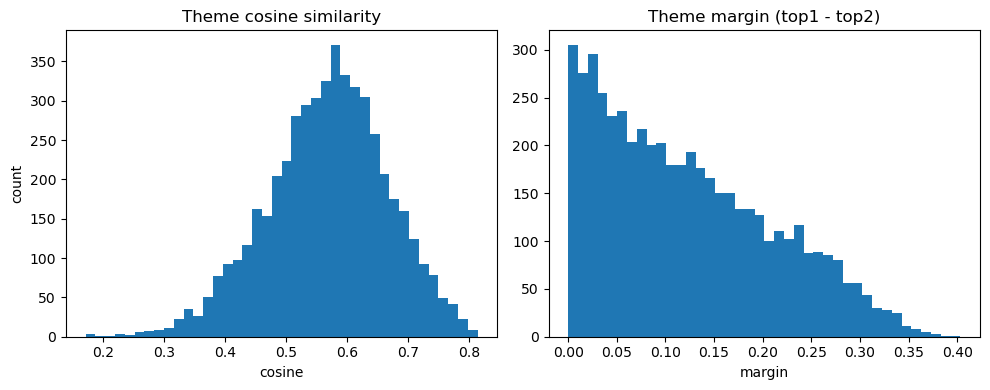

In [22]:
# === CHECKS & DIAGNOSTICS ===

# theme confusion between Factiva 'source_theme' and predicted debate theme
if "source_theme" in df_chunk_pred.columns:
    ctab = pd.crosstab(df_chunk_pred["source_theme"], df_chunk_pred["pred_theme"])
    print("[INFO] source_theme vs pred_theme (chunk-level)")
    display(ctab)
else:
    print("[WARN] 'source_theme' not present; skipping source vs predicted confusion.")

# quick distributions for similarity & margins (theme and subtheme)
desc_cols = ["pred_sim", "margin"]
if "pred_sub_sim" in df_chunk_pred.columns:
    desc_cols += ["pred_sub_sim", "sub_margin"]

print("\n[INFO] similarity / margin summary:")
display(df_chunk_pred[desc_cols].describe())

# quick histogram (comment out if you prefer text-only)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_chunk_pred["pred_sim"], bins=40)
axes[0].set_title("Theme cosine similarity")
axes[0].set_xlabel("cosine")
axes[0].set_ylabel("count")

axes[1].hist(df_chunk_pred["margin"], bins=40)
axes[1].set_title("Theme margin (top1 - top2)")
axes[1].set_xlabel("margin")
plt.tight_layout()
plt.show()

**1. Cosine Similarity & Margin**
- *Cosine similarity* (left histogram): most media chunks align moderately well with debate themes, peaking around **0.55–0.65**. Few chunks are very low (<0.3) or very high (>0.8).
- *Margin* (right histogram): the difference between top-1 and top-2 themes is usually small (**~0.05–0.15**), meaning many assignments are ambiguous. Only a minority of chunks have a strong, unambiguous theme (>0.25 margin).

**2. Confusion Table (Source Theme vs Predicted Theme)**
- Strong diagonal → many chunks correctly map back to the intended theme (e.g., 1,414 foreign policy, 938 healthcare, 1,138 immigration).
- Off-diagonal drift → semantic overlap between themes:
  - *Foreign policy* → sometimes mapped to *china_global_trade*.
  - *Healthcare* → sometimes mapped to *partisan gridlock* or *judiciary*.
  - *Immigration* → sometimes mapped to *civil rights* or *partisan gridlock*.
- This is expected since:
  - Factiva queries are **broad labels**.
  - Debate themes are **finer-grained**.
  - SBERT embeddings capture **semantic overlap**.

**3. Descriptive Stats**
- **Theme similarity**: avg 0.57 (range 0.17–0.81).
- **Theme margin**: avg 0.12 → best theme is only slightly better than the runner-up.
- **Subtheme similarity**: avg 0.54, margins even lower (~0.09), meaning subthemes are noisier.

**4. Key Takeaways**
- Treat assignments as **probabilistic signals**, not perfect categories.
- Use **margins** to triage:
  - High-margin chunks = high-confidence alignment.
  - Low-margin chunks = ambiguous, possibly exclude or soft-weight.
- Subthemes are useful for **exploration** but less stable; best to apply thresholds (e.g., `pred_sub_sim > 0.6` and `margin > 0.15`) to keep only confident cases.

### 6.5. Chunk Filtering (Balanced Outlet Distribution)

In [26]:
# === MODERATE FILTERING ===

# thresholds (moderate, if we do the correct values, we're left with very little chunks)
THEME_SIM_MIN    = 0.45
THEME_MARGIN_MIN = 0.05
SUB_SIM_MIN      = 0.45
SUB_MARGIN_MIN   = 0.05

mask = (
    (df_chunk_pred["pred_sim"]     >= THEME_SIM_MIN) &
    (df_chunk_pred["margin"]       >= THEME_MARGIN_MIN) &
    (df_chunk_pred["pred_sub_sim"] >= SUB_SIM_MIN) &
    (df_chunk_pred["sub_margin"]   >= SUB_MARGIN_MIN)
)
df_filtered = df_chunk_pred[mask].copy()
print(f"[INFO] Filtered chunks: {len(df_filtered):,} / {len(df_chunk_pred):,} "
      f"({100*len(df_filtered)/len(df_chunk_pred):.1f}%)")

[INFO] Filtered chunks: 2,079 / 5,050 (41.2%)


In [27]:
# === CONFIDENCE SCORE ===

# combine main + subtheme sim/margin into one ranking score
df_filtered["conf_score"] = (
    df_filtered["pred_sim"] +
    0.5 * df_filtered["margin"] +
    df_filtered["pred_sub_sim"] +
    0.5 * df_filtered["sub_margin"]
)

# quick sanity
print("[QC] Confidence score stats:")
print(df_filtered["conf_score"].describe())

[QC] Confidence score stats:
count    2079.000000
mean        1.437869
std         0.204019
min         0.991039
25%         1.272180
50%         1.434582
75%         1.586002
max         2.012132
Name: conf_score, dtype: float64


In [28]:
# === OUTLET BALANCING ===

# find the smallest outlet pool
outlet_counts = df_filtered["outlet"].value_counts()
min_n = outlet_counts.min()
print("[INFO] Outlet counts after filtering:\n", outlet_counts)
print(f"[INFO] Balancing to {min_n} chunks per outlet")

# rank within outlet by confidence and keep top-N
df_balanced = (
    df_filtered
    .sort_values(["outlet", "conf_score"], ascending=[True, False])
    .groupby("outlet")
    .head(min_n)
    .reset_index(drop=True)
)

print(f"[DONE] Balanced dataset: {len(df_balanced):,} chunks "
      f"({min_n} per outlet × {df_balanced['outlet'].nunique()} outlets)")

# peek at balanced set
display(df_balanced.sample(5))

[INFO] Outlet counts after filtering:
 outlet
nyt    1247
wsj     607
nyp     225
Name: count, dtype: int64
[INFO] Balancing to 225 chunks per outlet
[DONE] Balanced dataset: 675 chunks (225 per outlet × 3 outlets)


,__media_id,year,outlet,source_theme,chunk_index,chunk_text,pred_theme,pred_sim,second_theme,second_sim,margin,chunk_preview,pred_subtheme_parent,pred_subtheme,pred_sub_sim,second_sub_idx,second_sub_sim,sub_margin,conf_score
209,871,2020,nyp,immigration_borders,2,"it's personal and it's everywhere, meaning the...",partisan_gridlock_new_leadership,0.488670,civil_rights_law_enforcement,0.413027,0.075643,"it's personal and it's everywhere, meaning the...",civil_rights_law_enforcement,race_in_political_discourse,0.497163,8,0.375922,0.121240,1.084275
474,501,2016,wsj,healthcare_public_health,2,the same results that are now unspooling natio...,healthcare_social_security,0.731291,partisan_gridlock_new_leadership,0.485909,0.245381,the same results that are now unspooling natio...,healthcare_social_security,affordable_care_health_insurance,0.777209,11,0.479843,0.297366,1.779873
49,291,2024,nyp,foreign_policy_national_security,1,"""he wants to make peace,"" trump told the post ...",foreign_policy_national_security,0.602261,partisan_gridlock_new_leadership,0.347277,0.254984,"""he wants to make peace,"" trump told the post ...",foreign_policy_national_security,russia_soviet_union,0.637872,5,0.517461,0.120412,1.427831
670,58,2012,wsj,foreign_policy_national_security,6,the 2007 troop surge. the obama administration...,foreign_policy_national_security,0.623989,partisan_gridlock_new_leadership,0.397762,0.226227,the 2007 troop surge. the obama administration...,foreign_policy_national_security,afghanistan_alqaeda_binladen,0.687866,9,0.559578,0.128287,1.489112
512,517,2016,wsj,healthcare_public_health,2,generous -- that working families' benefits ne...,healthcare_social_security,0.731584,tax_policy,0.490629,0.240956,generous -- that working families' benefits ne...,healthcare_social_security,affordable_care_health_insurance,0.723492,16,0.529941,0.193551,1.672329


## 7. Exports

In [34]:
# === ADD OUTLET LEANING COLUMN (R/D/NaN) ===

import numpy as np

LEAN_MAP = {
    "nyp": "R",   # New York Post
    "nyt": "D",   # The New York Times
    "wsj": np.nan # Wall Street Journal → centrist/market; keep NaN per earlier convention
}

def add_outlet_leaning(df, outlet_col="outlet"):
    if outlet_col not in df.columns:
        raise KeyError(f"Column '{outlet_col}' not found in DataFrame.")
    out = df.copy()
    out["outlet_leaning"] = out[outlet_col].astype(str).str.lower().map(LEAN_MAP)
    return out

# apply to all variants we export
df_chunk_pred = add_outlet_leaning(df_chunk_pred, "outlet")
df_filtered   = add_outlet_leaning(df_filtered,   "outlet")
df_balanced   = add_outlet_leaning(df_balanced,   "outlet")

# quick sanity
print("[QC] outlet_leaning counts (full):")
print(df_chunk_pred["outlet_leaning"].value_counts(dropna=False))
print("\n[QC] outlet_leaning counts (filtered):")
print(df_filtered["outlet_leaning"].value_counts(dropna=False))
print("\n[QC] outlet_leaning counts (balanced):")
print(df_balanced["outlet_leaning"].value_counts(dropna=False))

[QC] outlet_leaning counts (full):
outlet_leaning
D      2489
NaN    1549
R      1012
Name: count, dtype: int64

[QC] outlet_leaning counts (filtered):
outlet_leaning
D      1247
NaN     607
R       225
Name: count, dtype: int64

[QC] outlet_leaning counts (balanced):
outlet_leaning
R      225
D      225
NaN    225
Name: count, dtype: int64


In [35]:
# === SAVE DATASETS ===

EXPORT_DIR = DATA_DIR / "embeddings"/ "debates_media_theme_alignment_processed"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# full predictions (all chunks, with sims + margins)
full_path = MEDIA_DIR / "media_chunks_pred_full.csv"
df_chunk_pred.to_csv(full_path, index=False)
print(f"[SAVED] Full predictions → {full_path} ({len(df_chunk_pred):,} rows)")

# filtered chunks (moderate thresholds)
filtered_path = DATA_DIR / "important" / "media_chunks_pred_filtered.csv"
df_filtered.to_csv(filtered_path, index=False)
print(f"[SAVED] Filtered chunks → {filtered_path} ({len(df_filtered):,} rows)")

# balanced subset (equal chunks per outlet)
balanced_path = DATA_DIR / "important"/ "media_chunks_pred_balanced.csv"
df_balanced.to_csv(balanced_path, index=False)
print(f"[SAVED] Balanced chunks → {balanced_path} ({len(df_balanced):,} rows)")

[SAVED] Full predictions → /Users/emmamora/Documents/GitHub/thesis/data/media/media_chunks_pred_full.csv (5,050 rows)
[SAVED] Filtered chunks → /Users/emmamora/Documents/GitHub/thesis/data/important/media_chunks_pred_filtered.csv (2,079 rows)
[SAVED] Balanced chunks → /Users/emmamora/Documents/GitHub/thesis/data/important/media_chunks_pred_balanced.csv (675 rows)


In [36]:
# === SAVE OUTLET/THEME COUNTS ===

# outlet distribution
outlet_counts_path = EXPORT_DIR / "outlet_counts.csv"
df_balanced["outlet"].value_counts().to_csv(outlet_counts_path)
print(f"[SAVED] Outlet counts → {outlet_counts_path}")

# theme distribution
theme_counts_path = EXPORT_DIR / "theme_counts.csv"
df_balanced["pred_theme"].value_counts().to_csv(theme_counts_path)
print(f"[SAVED] Theme counts → {theme_counts_path}")

[SAVED] Outlet counts → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/debates_media_theme_alignment_processed/outlet_counts.csv
[SAVED] Theme counts → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/debates_media_theme_alignment_processed/theme_counts.csv


In [37]:
# === OPTIONAL: SAVE EMBEDDINGS FOR MEDIA CHUNKS ===

# store embeddings aligned with balanced set
balanced_ids = df_balanced[MEDIA_ID_COL].values
mask = med_idx[MEDIA_ID_COL].isin(balanced_ids).values
balanced_emb = med_emb[mask]

emb_path = EXPORT_DIR / "media_chunks_balanced_sbert.npy"
np.save(emb_path, balanced_emb)
print(f"[SAVED] Balanced embeddings → {emb_path} ({balanced_emb.shape})")

print("[DONE] All exports complete.")

[SAVED] Balanced embeddings → /Users/emmamora/Documents/GitHub/thesis/data/embeddings/debates_media_theme_alignment_processed/media_chunks_balanced_sbert.npy ((1696, 384))
[DONE] All exports complete.
